In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm

# Pricing par méthode de Monte-Carlo

# Méthode de simulation

On a l'expression du rendement de l'actif sous-jacent S :

$\frac{dS_t}{S_t}=(r-d)d t+\sigma d W_t$

où r, d, σ, W sont respectivement le taux sans risque, le taux de dividende, la volatilité et le mouvement brownien.

# Mouvement brownien

Créons tout d'abord une fonction permettant de récupérer les différents $t_i$ ainsi que les $dt$, cela nous sera utile par la suite

In [2]:
def delta_t(n, T):
    """
    Pour n et T donnés, renvoie les t_i ainsi que l'incrément de temps dt
    """
    t = np.linspace(0, T, n)
    dt = t[1] - t[0]
    return t, dt

In [3]:
delta_t(5,10)

(array([ 0. ,  2.5,  5. ,  7.5, 10. ]), 2.5)

Définissons maintenant le mouvement brownien :

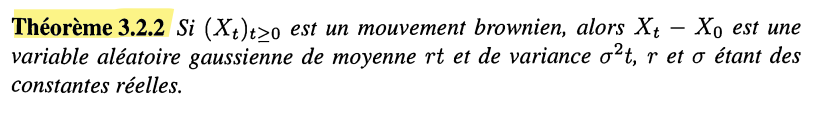

In [4]:
def mouvement_brownien(n, T, x0, r, sigma):
    """
    Renvoie une liste contenant les valeurs du mouvement brownien du temps 0 à T
    """
    t, dt = delta_t(n, T)
    B = np.zeros(n)
    B[0] = x0
    for i in range(1, n):
        B[i] = B[i-1] + np.random.normal(loc=r*dt, scale=sigma*np.sqrt(dt))
    return B

Profitons-en pour créer une fonction créant le mouvement brownien standard, cela simplifiera les notations

In [5]:
def mouvement_brownien_standard(n, T):
    return mouvement_brownien(n, T, 0, 0, 1)

## Simulation d'un mouvement brownien

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
[ 0.         -0.0862375  -0.27903216 -0.26211806 -0.91976067 -0.79901513
 -0.60000692 -0.35269381 -0.5432102  -0.5282035 ]


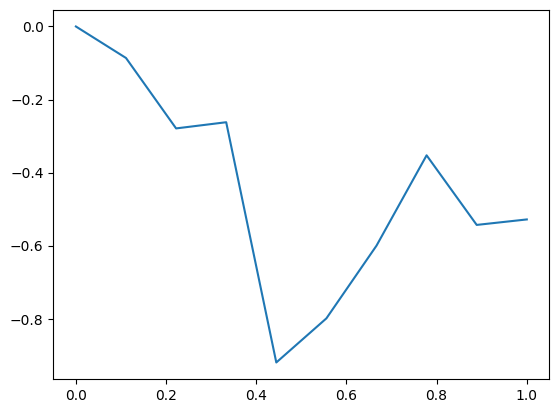

In [6]:
n = 10
T = 1
t, dt = delta_t(n, T)
W = mouvement_brownien_standard(n, T)
print(t)
print(W)
plt.plot(t,W)

## Simulation de 10 mouvements browniens

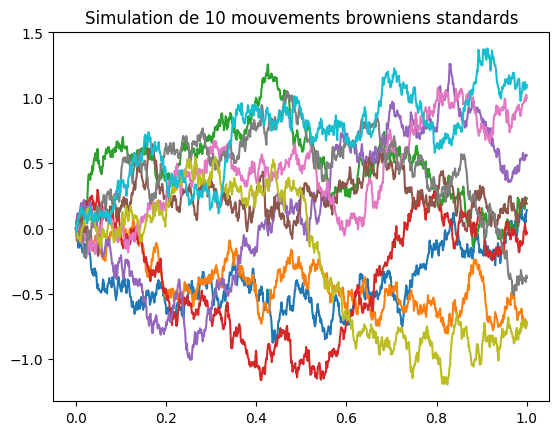

In [7]:
n = 1000
T = 1
for j in range(10):
    t, dt = delta_t(n, T)
    B = mouvement_brownien_standard(n, T)
    plt.plot(t, B)
    plt.title("Simulation de 10 mouvements browniens standards")

# Formule de Black-Scholes

On a la formule de Black-Scholes :

$dS_t = S_t(\mu dt + \sigma dB_t)$

où $\mu$ et $\sigma$ sont deux constantes et $(B_t)$ un mouvement brownien standard.

Soit 

$S_t = S_0 \exp (\mu t - \frac{\sigma^2}{2}t + \sigma B_t)$

Avec les notations de l'exercice on a :

$S_t = S_0 \exp ((r-d) t - \frac{\sigma^2}{2}t + \sigma W_t)$

In [8]:
def black_scholes(S0, n, T, r, d, sigma, renvoie_brownien=False):
    """
    Renvoie une liste contenant l'évolution du prix d'un actif sous-jacent suivant le modèle de Black-Scholes
    Peut aussi renvoyer le mouvement brownien correspondant
    """
    temps, dt = delta_t(n, T)
    W = mouvement_brownien_standard(n, T)
    S = []
    for t, Wt in zip(temps, W):
        S.append(S0*np.exp((r-d)*t - sigma**2*t/2 + sigma*Wt))
    if renvoie_brownien:
        return S, W
    return S

## Fonction permettant une représentation de l'évolution du prix du sous-jacent

In [9]:
def plot_black_scholes(S0, n, T, r, d, sigma, nb_simu):
    fig, ax = plt.subplots(2)
    temps, dt = delta_t(n, T)
    for _ in range(nb_simu):
        prix, W = black_scholes(S0, n, T, r, d, sigma, renvoie_brownien=True)
        ax[0].plot(temps, W)
        ax[0].set_title("Mouvement brownien")
        ax[0].label_outer()
        ax[1].plot(temps, prix)
        ax[1].set_title("Evolution du prix du sous-jacent")

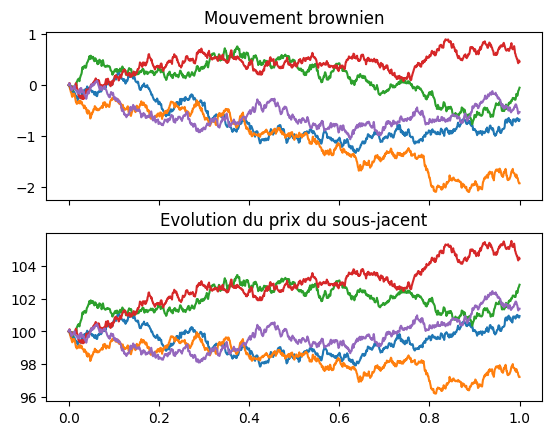

In [10]:
S0 = 100
n = 1000
T = 1
r = 0.05
d = 0.02
volatilite = 0.03
nb_simulations = 5
plot_black_scholes(S0, n, T, r, d, volatilite, nb_simulations)

## Simulation paramétrique

Supposons des simulations sur 3 ans, avec des variations du taux sans risque, des taux de dividende et de la volatilité :

In [11]:
T = 3
n = 9000
temps, dt = delta_t(n, T)
nb_1_an = n//T

### Taux sans risque

Nous modélisons le taux sans risque par un mouvement brownien valant 3% à l'origine et de volatilité 0.01

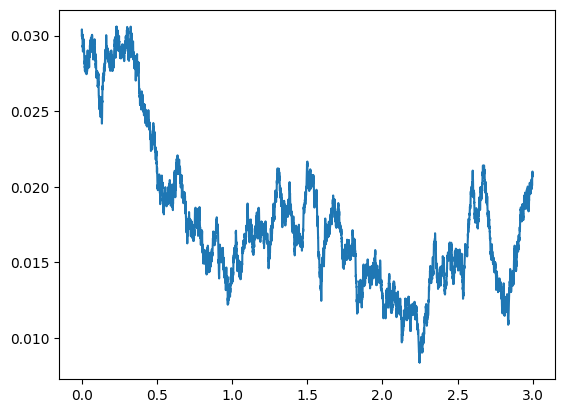

In [12]:
taux_sans_risque = mouvement_brownien(n,T,0.03,0,0.01)
plt.plot(temps, taux_sans_risque)

### Taux de dividende

Nous modélisons le taux de dividende par un mouvement brownien valant 3% à l'origine, de moyenne croissante, 0.01, et de volatilité 0.05

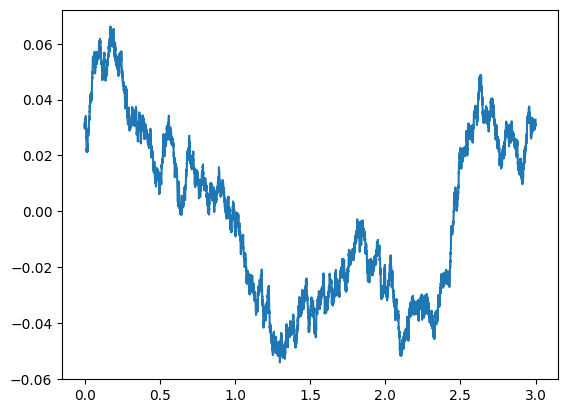

In [13]:
taux_dividende = mouvement_brownien(n,T,0.03,0.01,0.05)
plt.plot(temps, taux_dividende)

### Volatilité

Nous modélisons la volatilité par un mouvement brownien ayant une volatilité de 0.01

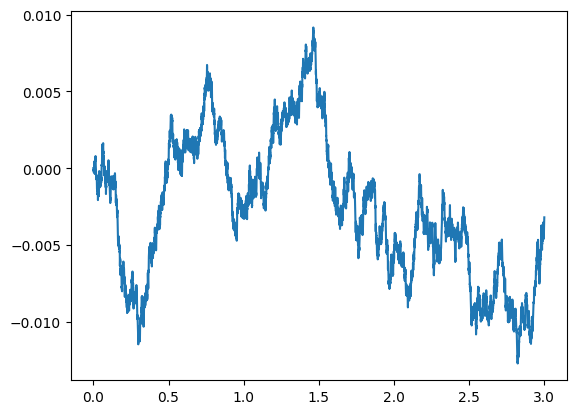

In [14]:
volatilite = mouvement_brownien(n,T,0,0,0.01)
plt.plot(temps,volatilite)

### Ensemble des paramètres

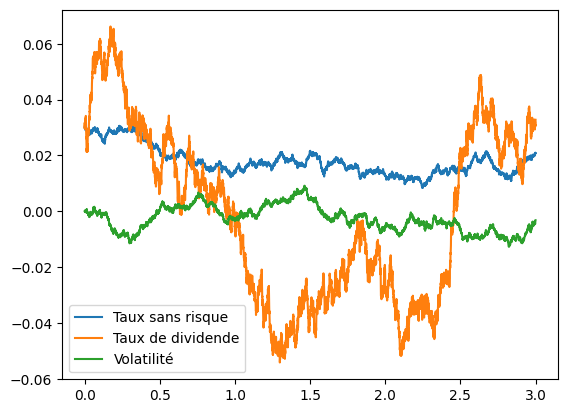

In [15]:
plt.plot(temps, taux_sans_risque)
plt.plot(temps, taux_dividende)
plt.plot(temps, volatilite)
plt.legend(["Taux sans risque","Taux de dividende","Volatilité"])

In [16]:
def black_scholes_para(S0, n, T, r, d, sigma, renvoie_brownien=False):
    W = mouvement_brownien_standard(n, T)
    temps, dt = delta_t(n, T)
    S = []
    for t, W_t, r_t, d_t, sigma_t in zip(temps, W, r, d, sigma):
        S.append(S0*np.exp((r_t-d_t)*t - sigma_t**2*t/2 + sigma_t*W_t))
    if renvoie_brownien:
        return S, W
    return S

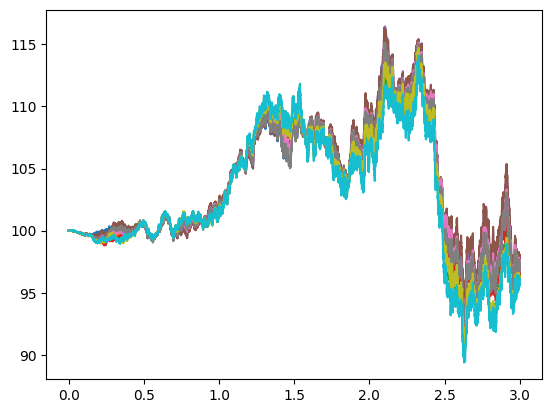

In [17]:
temps, dt = delta_t(n, T)
for _ in range(10):
    S = black_scholes_para(S0, n, T, taux_sans_risque, taux_dividende, volatilite)
    plt.plot(temps, S)

# Payoff

## Call européen

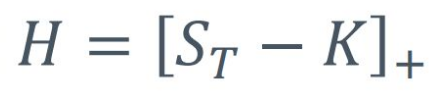

In [18]:
def call_europeen(S, K):
    return max(S[-1]-K, 0)

100%|█| 100/100 [00:00<00:00, 171.00it/


(array([85.,  2.,  4.,  1.,  1.,  4.,  2.,  0.,  0.,  1.]),
 array([0.        , 0.93535586, 1.87071172, 2.80606759, 3.74142345,
        4.67677931, 5.61213517, 6.54749104, 7.4828469 , 8.41820276,
        9.35355862]),
 <BarContainer object of 10 artists>)

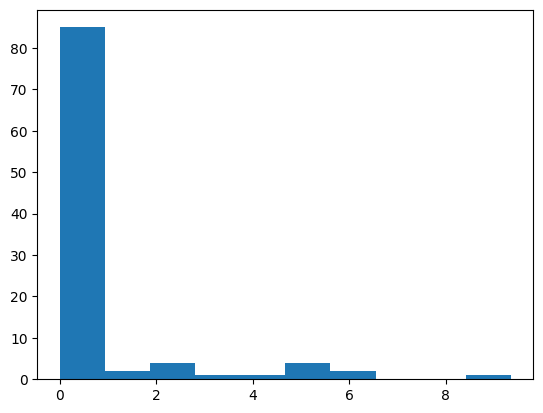

In [19]:
T = 1
n = T*3000
temps, dt = delta_t(n, T)
S0 = 100
K = 103
H = []
taux_sans_risque = 0.02
taux_dividende = 0.03
volatilite = 0.05
for _ in tqdm(range(100)):
    S = black_scholes(S0, n, T, taux_sans_risque, taux_dividende, volatilite)
    H.append(call_europeen(S, K))
plt.hist(H)

## Option asiatique

### Dans le cas continu

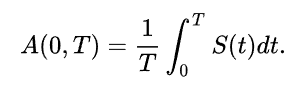

### Dans le cas discret

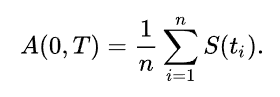

In [20]:
def call_asiatique(S, K):
    return max(np.mean(S)-K, 0)

100%|█| 100/100 [00:00<00:00, 167.24it/


Text(0.5, 1.0, "Payoff d'une option asiatique")

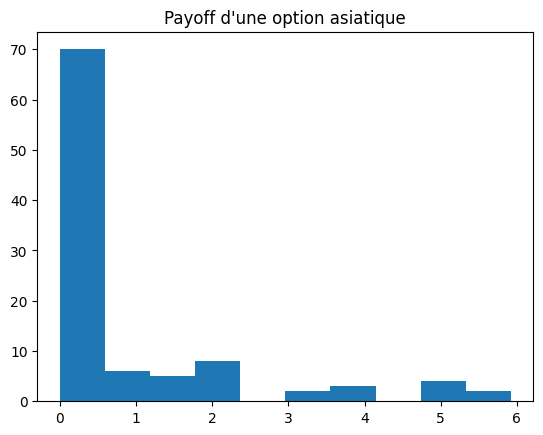

In [21]:
T = 1
n = T*3000
temps, dt = delta_t(n, T)
S0 = 100
K = 101
H = []
for _ in tqdm(range(100)):
    S = black_scholes(S0, n, T, taux_sans_risque, taux_dividende, volatilite)
    H.append(call_asiatique(S, K))
plt.hist(H)
plt.title("Payoff d'une option asiatique")

# Prix initial

Calculons maintenant le prix initial de l'option asiatique. On a les formules suivantes :

$\pi _0^H = \frac{1}{(1+r)^N}\mathbb{E}_*(H)$

ou

$\pi _0^H = e^{-rT}\mathbb{E}_*(H)$

In [22]:
def prix_instant_initial(taux_sans_risque, T, esperance_h):
    return np.exp(-taux_sans_risque*T)*esperance_h

In [23]:
T = 3
n = T*3000
temps, dt = delta_t(n, T)
# taux_sans_risque = [0.03]*n
S0 = 100
K = 101
H = []
for _ in tqdm(range(100)):
    S = black_scholes(S0, n, T, taux_sans_risque, taux_dividende, volatilite)
    H.append(call_asiatique(S, K))

100%|█| 100/100 [00:04<00:00, 20.71it/s


In [24]:
esperance_h = np.mean(H)
esperance_h

0.9734162410893614

In [25]:
prix_instant_initial(0.03, T, esperance_h)

0.8896354589810637

## Simulations demandées

In [40]:
S0 = 100
sigma = 0.1
r = 0.05
d = 0.03
K = 103
liste_simu = [10*n for n in range(1,2)]

### T = 1 an, et les tj correspondent aux mois

1.44 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


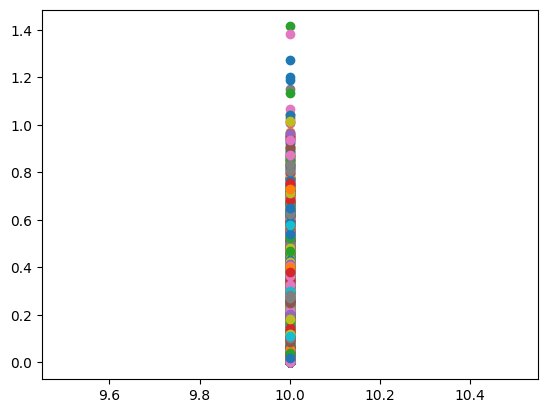

In [41]:
%%timeit
T = 1
n = 12
liste_prix = []
for nb_simu in liste_simu:
    H = []
    for _ in range(nb_simu):
        S = black_scholes(S0, n, T, taux_sans_risque, taux_dividende, volatilite)
        H.append(call_asiatique(S, K))
    esperance_h = np.mean(H)
    liste_prix.append(prix_instant_initial(0.03, T, esperance_h))
plt.plot(liste_simu, liste_prix,'o')

### T = 1 an, et les tj correspondent aux trimestres

In [28]:
%%timeit
T = 1
n = 4
for _ in range(nb_simulations):
    S = black_scholes(S0, n, T, taux_sans_risque, taux_dividende, volatilite)
    H.append(call_asiatique(S, K))
esperance_h = np.mean(H)
prix_instant_initial(0.03, T, esperance_h)

90 ms ± 5.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### T = 1 an, et les tj correspondent aux semaines

In [29]:
%%timeit
T = 1
n = 52
for _ in range(nb_simulations):
    S = black_scholes(S0, n, T, taux_sans_risque, taux_dividende, volatilite)
    H.append(call_asiatique(S, K))
esperance_h = np.mean(H)
prix_instant_initial(0.03, T, esperance_h)

380 ms ± 43.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Pricing d'options barrières

In [30]:
def black_scholes_barrier_option(S, K, T, r, sigma, H, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Mauvais type d'option")
    
    # Barriere
    if option_type == 'call' and S > H:
        return 0.0 
    elif option_type == 'put' and S < H:
        return 0.0
    else:
        return option_price

### Call down and out avec barrière H = 80 et dates barrie`res mensuelles

In [31]:
S0 = 100
sigma = 0.1
r = 0.05
d = 0.03
K = 103
nb_simulations = 1000

In [32]:
H = 80

call_price = black_scholes_barrier_option(S0, K, T, r, sigma, H, option_type='call')
print(call_price)

0.0
